In [187]:
import yfinance as yf

df = yf.download(tickers='TSLA', period='10y', interval='1d')
df['Change'] = (df['Close'].shift(-1) - df['Close']) / df['Close']
df = df.iloc[:-1]
# df.tail(30)

[*********************100%%**********************]  1 of 1 completed


In [188]:
import pandas as pd

df.index = pd.to_datetime(df.index)

start_date = df.index.min()
end_date = df.index.max() 
all_dates = pd.date_range(start=start_date, end=end_date, freq='B')

missing_dates = all_dates.difference(df.index)

missing_count = len(missing_dates)
# print(f"Number of missing dates: {missing_count}")
# print("Missing dates:")
# print(missing_dates)
# rows_with_nan = df[df.isna().any(axis=1)]
# print(rows_with_nan)


In [189]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# df = df.sort_values(by="Date", ascending=True).reset_index(drop=True)


X = df[['Open', 'High', 'Low', 'Close']]
y = df['Change']

train_size = int(len(df) * 0.8)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size:]
y_val = y.iloc[train_size:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)


In [190]:
model = XGBRegressor(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.01, 0.1, 0.001, 0.0001],
    'max_depth': [2, 3, 5, 7],
    'lambda': [0.01, 0.1, 1, 2, 5, 10, 50, 100]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=tscv,
    n_jobs=-1,            
    verbose=1
)


grid_search.fit(X_train_scaled, y_train)
print("Best parameters from GridSearchCV:", grid_search.best_params_)
print("Best CV Score (MSE):", grid_search.best_score_)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits
Best parameters from GridSearchCV: {'lambda': 100, 'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 50}
Best CV Score (MSE): -0.0013965898045196364


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=100, learning_rate=0.0001,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, ...)

In [194]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled,y_train)


y_val_pred = best_model.predict(X_val_scaled)

mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print("Validation MSE:", mse)
print("Validation r2:", r2)

Validation MSE: 0.00137435598981116
Validation r2: -0.0013424265809691693


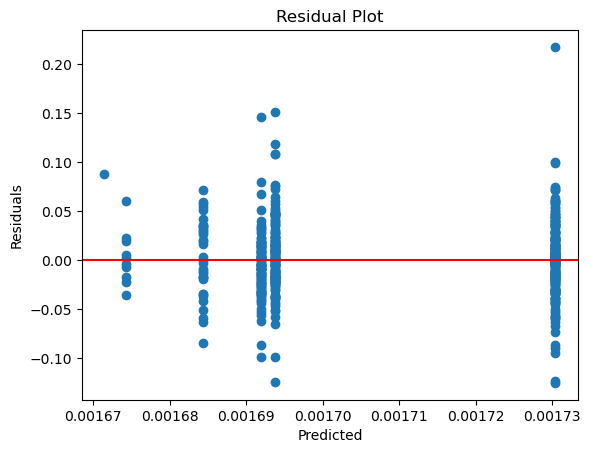

In [192]:
import matplotlib.pyplot as plt

residuals_val = y_val - y_val_pred
plt.scatter(y_val_pred, residuals_val)
plt.axhline(0, color='red')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [193]:
df_new = yf.download(tickers='TSLA', period='1y', interval='1d')
new_data = df[['Open', 'High', 'Low', 'Close']]
new_data = new_data.iloc[-1:]
print(new_data)

new_data_scaled = scaler.transform(new_data)

predictions = best_model.predict(new_data_scaled)

predictions

[*********************100%%**********************]  1 of 1 completed

                  Open   High     Low       Close
Date                                             
2024-12-30  419.399994  427.0  415.75  417.410004


array([0.0016843], dtype=float32)